In [7]:
import importlib
import modules

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt


Transient length: no transient found


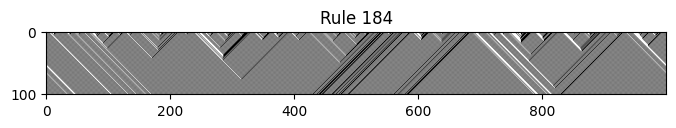

In [11]:
ca_184 = CA()

p = 0.8
L = 1000
initial_state = ca_184.gen_initial_state_bernoulli(L, p)
lambda_parameter, evolution = ca_184.gen_CA(L, r=1, k=2, dec_rule=184, t_end=100, s_q='0')
transient_length = ca_184.calculate_transient_length()

plt.figure(figsize=(8,10))
plt.title(f'Rule 184')
plt.imshow(evolution, cmap='binary')

print(f"Transient length: {transient_length}")
